In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root = "drive/MyDrive/data/"

In [3]:
from datasetHAM10000 import HAM10000
from model import HAM10000_model
from trainer import Trainer

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch
from torch import nn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random

In [5]:
train_transform = transforms.Compose(
    [
        transforms.GaussianBlur(kernel_size=(5, 5)),
        transforms.RandomPerspective(),
        transforms.RandomRotation(180),
        transforms.ToTensor(), # Scale image to [0, 1]
    ])

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),   
    ])

In [6]:
dataset_train = HAM10000.load_from_file(root, train=True, transform=train_transform)
dataset_test = HAM10000.load_from_file(root, train=False, transform=test_transform)

In [7]:
print(f"Number of train examples: {len(dataset_train.df)}")
print(f"Number of test examples: {len(dataset_test.df)}")

Number of train examples: 2140
Number of test examples: 795


In [8]:
print(dataset_train.df["type"].value_counts())

Melanocytic nevi                 1479
Benign keratosis-like lesions     236
dermatofibroma                    197
Basal cell carcinoma              116
Actinic keratoses                  61
Vascular lesions                   27
Dermatofibroma                     24
Name: type, dtype: int64


In [9]:
def show_images(metadata):
    plt.figure(figsize=(10,10))

    size = len(metadata)

    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        val = random.randrange(size)

        image = mpimg.imread(metadata.iloc[val, 0])
        plt.imshow(image)
        plt.xlabel(metadata.iloc[val, 1])
    plt.show()

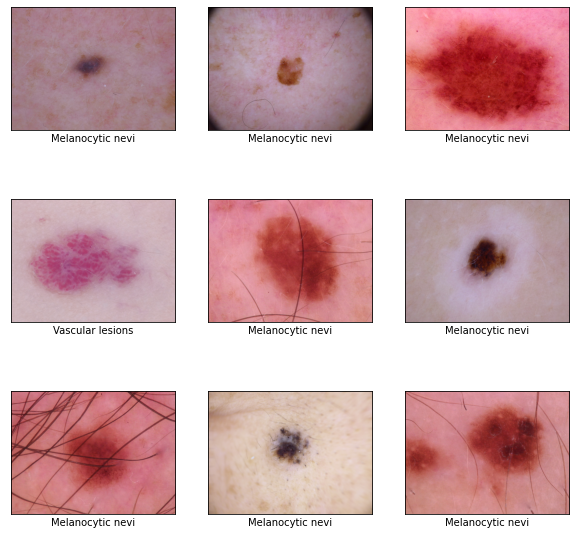

In [10]:
show_images(dataset_train.df)

In [11]:
batch_size = 64

In [12]:
train_data = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [14]:
model = HAM10000_model(7).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [15]:
epochs = 15

In [16]:
trainer = Trainer(model, optimizer, loss_function, device, scheduler=lr_scheduler)

In [17]:
metrics = trainer.train(train_data, test_data, epochs, keep_best=True)

Epoch 1/15, Train loss: 0.9160, Train accuracy: 0.6949, Test loss: 1.1900, Test accuracy: 0.6704 ---> Saved
Epoch 2/15, Train loss: 0.7030, Train accuracy: 0.7430, Test loss: 0.9500, Test accuracy: 0.7044 ---> Saved
Epoch 3/15, Train loss: 0.6975, Train accuracy: 0.7509, Test loss: 0.9136, Test accuracy: 0.7044 
Epoch 4/15, Train loss: 0.8591, Train accuracy: 0.7192, Test loss: 1.2178, Test accuracy: 0.6730 
Epoch 5/15, Train loss: 0.5530, Train accuracy: 0.7977, Test loss: 0.7656, Test accuracy: 0.7233 ---> Saved
Epoch 6/15, Train loss: 0.5480, Train accuracy: 0.7967, Test loss: 0.7745, Test accuracy: 0.7258 ---> Saved
Epoch 7/15, Train loss: 0.5237, Train accuracy: 0.8117, Test loss: 0.7658, Test accuracy: 0.7258 
Epoch 8/15, Train loss: 0.5086, Train accuracy: 0.8056, Test loss: 0.7426, Test accuracy: 0.7346 ---> Saved
Epoch 9/15, Train loss: 0.4966, Train accuracy: 0.8117, Test loss: 0.7500, Test accuracy: 0.7358 ---> Saved
Epoch 10/15, Train loss: 0.4908, Train accuracy: 0.8215, T

In [18]:
trainer.evaluate(test_data)

(0.7674879890221816, 0.7358490566037735)

In [20]:
trainer.save("model_mlbio.pth")

Model saved to model_mlbio.pth.
